# DSCI 100 Group Project -- Classifying an E-Mail as Spam or Not Spam 📧

## Developed by Aadi Kanwar, Stella Williams, Satvika Suresha, and Julian Piezas

## Introduction

E-Mail's can contain viruses which can harm one's computer system and their identity [CISA, 2023]("https://www.cisa.gov/news-events/news/virus-basics"). These "malicious" E-Mail's are often categorized as spam, whereas "benevolent" E-Mail's are categorized as "not-spam". Our group looks to explore this binary classification of E-Mail through the Spambase Dataset [(UCI ML Repo, 1999)]("https://archive.ics.uci.edu/dataset/94/spambase"). This dataset contains many variables regarding the frequency of strings in the E-Mails, which can be used to classify these E-Mail's. Our predictive question therefore becomes: "Can we use some of the features (namely character frequencies and length of sequences of capital letters) provided to us to predict whether a future E-Mail (unknown classification) is spam or not spam?". 

Word Count: 101 Words

## Preliminary Exploratory Data Analysis 

### Reading the dataset into R from the web (this data is raw, next step is cleaning!)

In [225]:
library(tidyverse)  # loading the tidyverse package for reading our data 
url1 <- "https://raw.githubusercontent.com/aadikanwar/DSCI100_group_project/main/spambase.data"  # URL for the raw dataset, taken from the uploaded data set from our GitHub repo
download.file(url1, "data/spambase_data.csv")  # downloading the file as a data file into the working directory 
spam <- "data/spambase_data.csv"
read_csv(spam, col_names = FALSE)  #reading the file into the notebook 
spam# this is a representation of the RAW data used for this project, we will clean in the upcoming cell 


Rows: 4601 Columns: 58
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (58): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,⋯,0.000,0.000,0.000,0.778,0.000,0.000,3.756,61,278,1
0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.000,0.132,0.000,0.372,0.180,0.048,5.114,101,1028,1
0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.010,0.143,0.000,0.276,0.184,0.010,9.821,485,2259,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.000,0.137,0.000,0.137,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.000,0.135,0.000,0.135,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.000,0.223,0.000,0.000,0.000,0.000,3.000,15,54,1
0.00,0.00,0.00,0,1.92,0.00,0.00,0.00,0.00,0.64,⋯,0.000,0.054,0.000,0.164,0.054,0.000,1.671,4,112,1
0.00,0.00,0.00,0,1.88,0.00,0.00,1.88,0.00,0.00,⋯,0.000,0.206,0.000,0.000,0.000,0.000,2.450,11,49,1
0.15,0.00,0.46,0,0.61,0.00,0.30,0.00,0.92,0.76,⋯,0.000,0.271,0.000,0.181,0.203,0.022,9.744,445,1257,1


[1] "data/spambase_data.csv"

### Cleaning and Wrangling the Data 

In [281]:
set.seed(200)
# install.packages('janitor')
# library(janitor) 
## we can pre-select some columns instead of naming all 58 columns, as the column names are described in the dataset location (DOI)
spam_data <- read_csv("data/spambase_data.csv", col_names = FALSE) |>
    select(49: 55, X58) |>
    rename("char_freq_semicolon" = "X49", "char_freq_paren" = "X50", "char_freq_brack" = "X51", "char_freq_excl" = "X52", "char_freq_mon" = "X53", "char_freq_hash" = "X54", "capital_run_length_average" = "X55", "spam_or_not_spam" = "X58") ## renaming the column names to proper names
    
spam_data <- spam_data |>
    mutate(spam_or_not_spam = as_factor(spam_or_not_spam))

spam_data <- spam_data |>
    mutate(spam_or_not_spam = fct_recode(spam_or_not_spam, "spam" = "1", "not_spam" = "0"))

spam_data


Rows: 4601 Columns: 58
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (58): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


char_freq_semicolon,char_freq_paren,char_freq_brack,char_freq_excl,char_freq_mon,char_freq_hash,capital_run_length_average,spam_or_not_spam
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.000,0.000,0.000,0.778,0.000,0.000,3.756,spam
0.000,0.132,0.000,0.372,0.180,0.048,5.114,spam
0.010,0.143,0.000,0.276,0.184,0.010,9.821,spam
0.000,0.137,0.000,0.137,0.000,0.000,3.537,spam
0.000,0.135,0.000,0.135,0.000,0.000,3.537,spam
0.000,0.223,0.000,0.000,0.000,0.000,3.000,spam
0.000,0.054,0.000,0.164,0.054,0.000,1.671,spam
0.000,0.206,0.000,0.000,0.000,0.000,2.450,spam
0.000,0.271,0.000,0.181,0.203,0.022,9.744,spam


spam_or_not_spam,count,percentage
<fct>,<int>,<dbl>
not_spam,2788,60.59552
spam,1813,39.40448


The data is clean and wrangled. Each row is a singular observation, each column is a singular variable, and each cell contains a singular value, and so this data is tidy. Names were added to the columns, the class column was converted to a factor and recoded to "spam" or "not_spam" from 1 and 0. 

Word Count: 55 Words

### Creating a Summary Table using Training Data

In [1]:
library(tidymodels) # for training and testing split 
library(dbplyr) # for the rename function 
set.seed(200) # to fix the randomization to one randomization
spam_split <- initial_split(spam_data, prop = 0.6, strata = spam_or_not_spam)  #splitting the data into training and testing data
spam_training <- training(spam_split)
spam_testing <- testing(spam_split)

summary_table_1 <- spam_training |>
    select(-spam_or_not_spam) |>              # computes the averages of variables in data, along with the number of NA's in data
    map_df(mean, na.rm = TRUE) |>
    mutate(num_of_na = sum(is.na(spam_training)))

summary_table_1 <- summary_table_1 |>  # renaming the names in the aforementioned table 
    rename("mean_;_freq" = "char_freq_semicolon", "mean_(_freq" = "char_freq_paren", "mean_[_freq" = "char_freq_brack", "mean_!_freq" = "char_freq_excl", "mean_$_freq" = "char_freq_mon", "mean_#_freq" = "char_freq_hash", "mean_capital_run" = "capital_run_length_average") 

summary_table_1

summary_table_2 <- tibble(dim(spam_training)) |>  
    rename("dim_of_training_rows_then_cols" = "dim(spam_training)") #dimensions of the training data
summary_table_3 <- tibble(dim(spam_testing)) |>
    rename("dim_of_testing_rows_then_cols" = "dim(spam_testing)")   #dimensions of the testing data

summary_table_2
summary_table_3


number_of_obs <- nrow(spam_testing)

summary_table_4 <- spam_testing |>  ## showing the percentage distribution of the classes spam and not spam
    group_by(spam_or_not_spam) |>   
    summarize(count = n(), percentage = n()/ number_of_obs * 100)

summary_table_4 <- summary_table_4 |>
    rename("classes" = "spam_or_not_spam")
summary_table_4

## it is important to recognize that scaling and centering WILL BE DONE after the proposal and during the actual classification

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ recipes      1.0.4
✔ dials        1.1.0     ✔ rsample      1.1.1
✔ dplyr        1.1.1     ✔ tibble       3.2.1
✔ ggplot2      3.4.2     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.0.1
✔ modeldata    1.0.1     ✔ workflows    1.1.2
✔ parsnip      1.0.3     ✔ workflowsets 1.0.0
✔ purrr        1.0.1     ✔ yardstick    1.1.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql




ERROR: Error in eval_select_impl(NULL, .vars, expr(c(!!!dots)), include = .include, : object 'spam_data' not found


### Creating Important Plots Comparing Distributions of Predictors and Varying Incomes, via the Training Data

Warning message:
“Removed 130 rows containing missing values (`geom_point()`).”


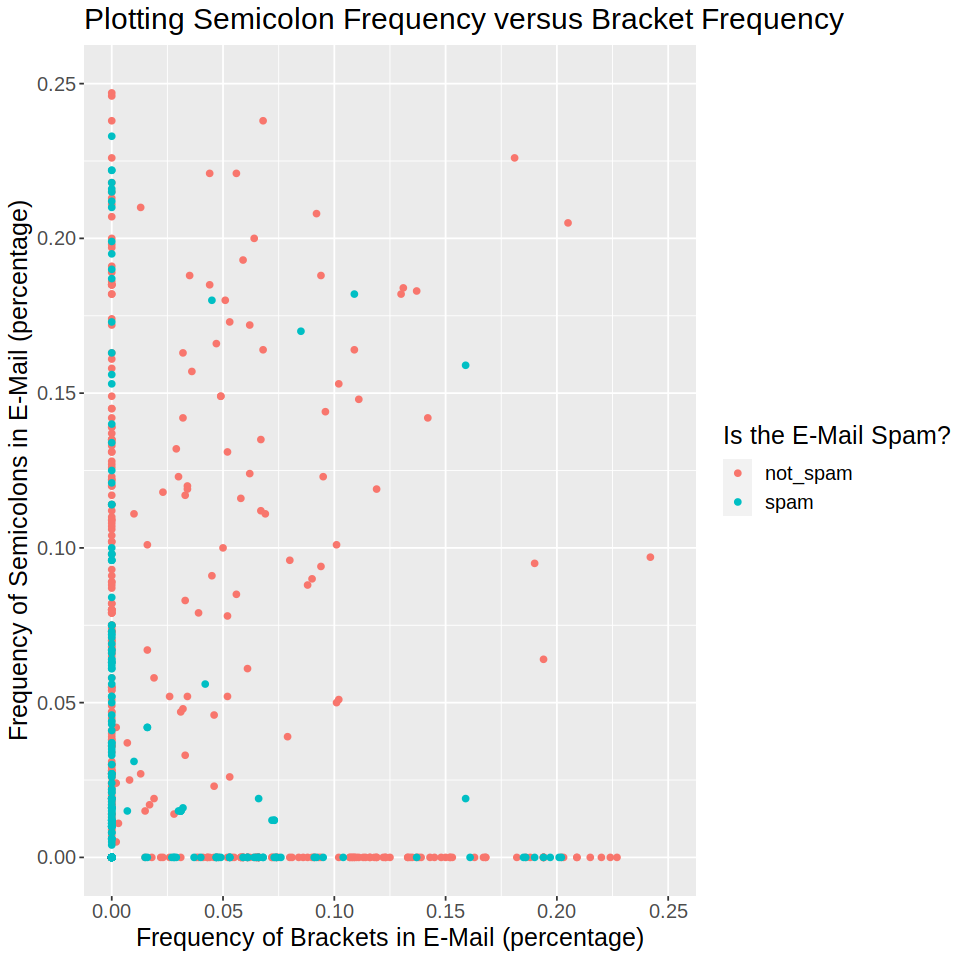

In [288]:
library(repr) # for setting the height and width of the plots 
# install.packages('png')
# library(png)


options(repr.plot.width = 8, repr.plot.height = 8)

spam_plot1 <- spam_training |>
    ggplot(aes(x = char_freq_brack, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point() +
    labs(x = "Frequency of Brackets in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.25)) +
    theme(text = element_text(size = 15)) +
    ggtitle("Plotting Semicolon Frequency versus Bracket Frequency")

spam_plot1
## OTHER GRAPHS CAN BE PLOTTED AS SUCH, BUT FOR SIMPLICITY, JUST THIS GRAPH IS PLOTTED FOR THE PROPOSAL

## The graphs tells us the relationship between two of the predictor variables, and is coloured by class of spam or not spam
## the importance of this graph lies in the fact that as the frequency of brackets and semicolons goes up, it is more likely for the e-mail to be spam
## this can lead to interesting conclusions as one may suspect the opposite case (excsessive brackets and semicolons leading to spam e-mail)

## Methods in Conducting Our Analysis 

### How will we conduct our analysis? What variables will we consider?

We will conduct our analysis via KNN classification, as we are considering a binary classification of "spam" or "not spam" E-Mails, which are categorical classifications. We will consider the result of our model through accuracy, and also precision/recall, to determine how our model treated positives and negatives. The raw dataset contained 58 features, but for the purpose of this project we consider 7: frequency of characters such as hard and soft brackets, semicolons, money symbols, exclamation points, and hash signs (**all as percentages**), as well as the average length of uninterrupted capital letters (i.e "AAABSsdA") has a length of 5 uninterrupted capitals. To choose these we took into account articles such as [(Forbes, 2010)]("https://www.forbes.com/sites/firewall/2010/03/17/the-most-common-words-in-spam-email/?sh=5f23e8df7d80"), which consider words that are most frequent in spam e-mails. These words often contain the aforementioned symbols (brackets, exclamations, etc.), and so we believed that it would make for a good classification to use these as our predictors.

Word Count: 149 Words

### How will we visualize our results?

We will visualize our results via multiple plots as shown above, considering all of the different features and colored by the class of "spam" or "not_spam". We can then create background fields of the colours of spam or not spam, to indicate how much of the graph would have been classified as spam and how much would have been classified as not spam, considering an arbitrary unknown observation. For our accuracy we will look to plot the K values versus our accuracy to see which K yields the best accuracy. 

Word Count: 90 Words 

## Expected Outcomes and Significance

### What do we expect to find?

We expect that E-Mail's with high frequency of the listed characters and long sequences of uninterrupted capitals will be classified as spam E-Mail's, and low frequency and sequences will be classified as "not spam". 

Word Count: 34 Words

### What impact could such findings have?

The findings in this project could aid data scientists to change their pre-existing classifiers for spam E-Mails, as there may be some results that do not align with their hypothesis'.

Word Count: 30 Words

### What future questions could this lead to?

This project could lead to questions about how E-Mail's should/should not be classified as spam; if high frequency characters do **not** lead to spam E-Mail, then data scientists may focus on low frequency characters, and vice versa. 

Word Count: 38 Words

### Total Word Count: 497 Words 

 ## References